In [1]:
from pathlib import Path as pt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sigfig
import json
import uncertainties as uc
import numpy as np

In [2]:
from load_data import (
    processed_data_dirs, plots_dir, titles, total_counts,
    models, models_labels, embeddings_dirname, embeddings_names, root_loc
)

tmpC_topelements_processed_data


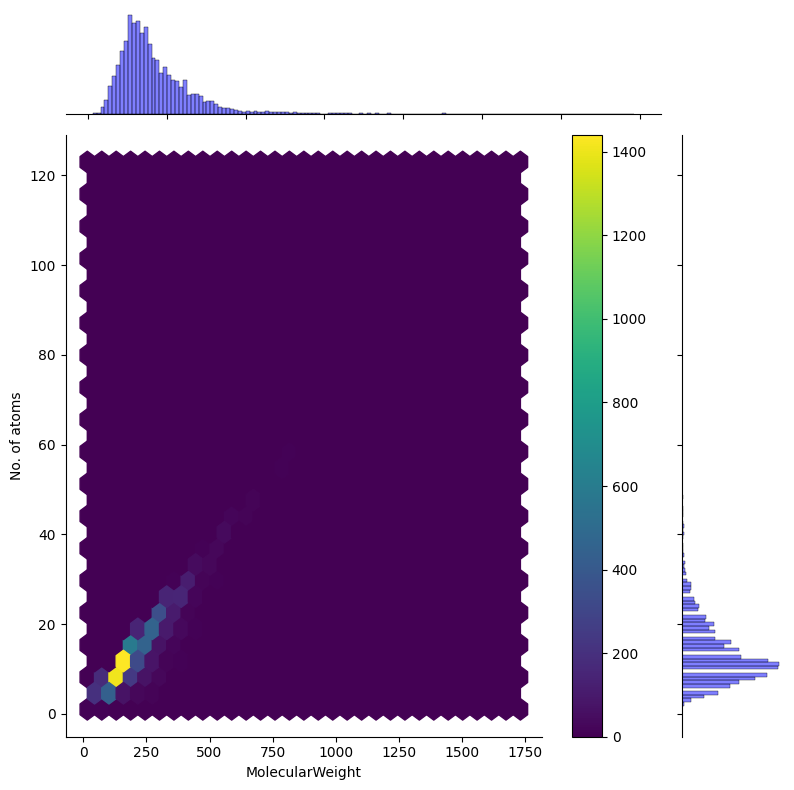

In [10]:
# %matplotlib widget
%matplotlib inline

plt.close('all')

data_dir = processed_data_dirs[0]
print(data_dir.name)
df = pd.read_csv(data_dir / "analysis_data/molecule_analysis_results.csv")
# print(df.columns)

sns.jointplot(
   data=df,
   x="MolecularWeight", 
   y="No. of atoms",
   kind="hex",
   height=8,
   joint_kws={'gridsize': 30},  # Increase number of hexagons
   cmap='viridis',  # Better colormap for visibility
   marginal_kws={'color': 'blue', 'alpha': 0.5}
)
plt.colorbar()  # Add colorbar to show counts
# Simple KDE plot
# plt.figure()
# sns.kdeplot(data=df, x="No. of atoms", fill=True, bw_adjust=0.5)

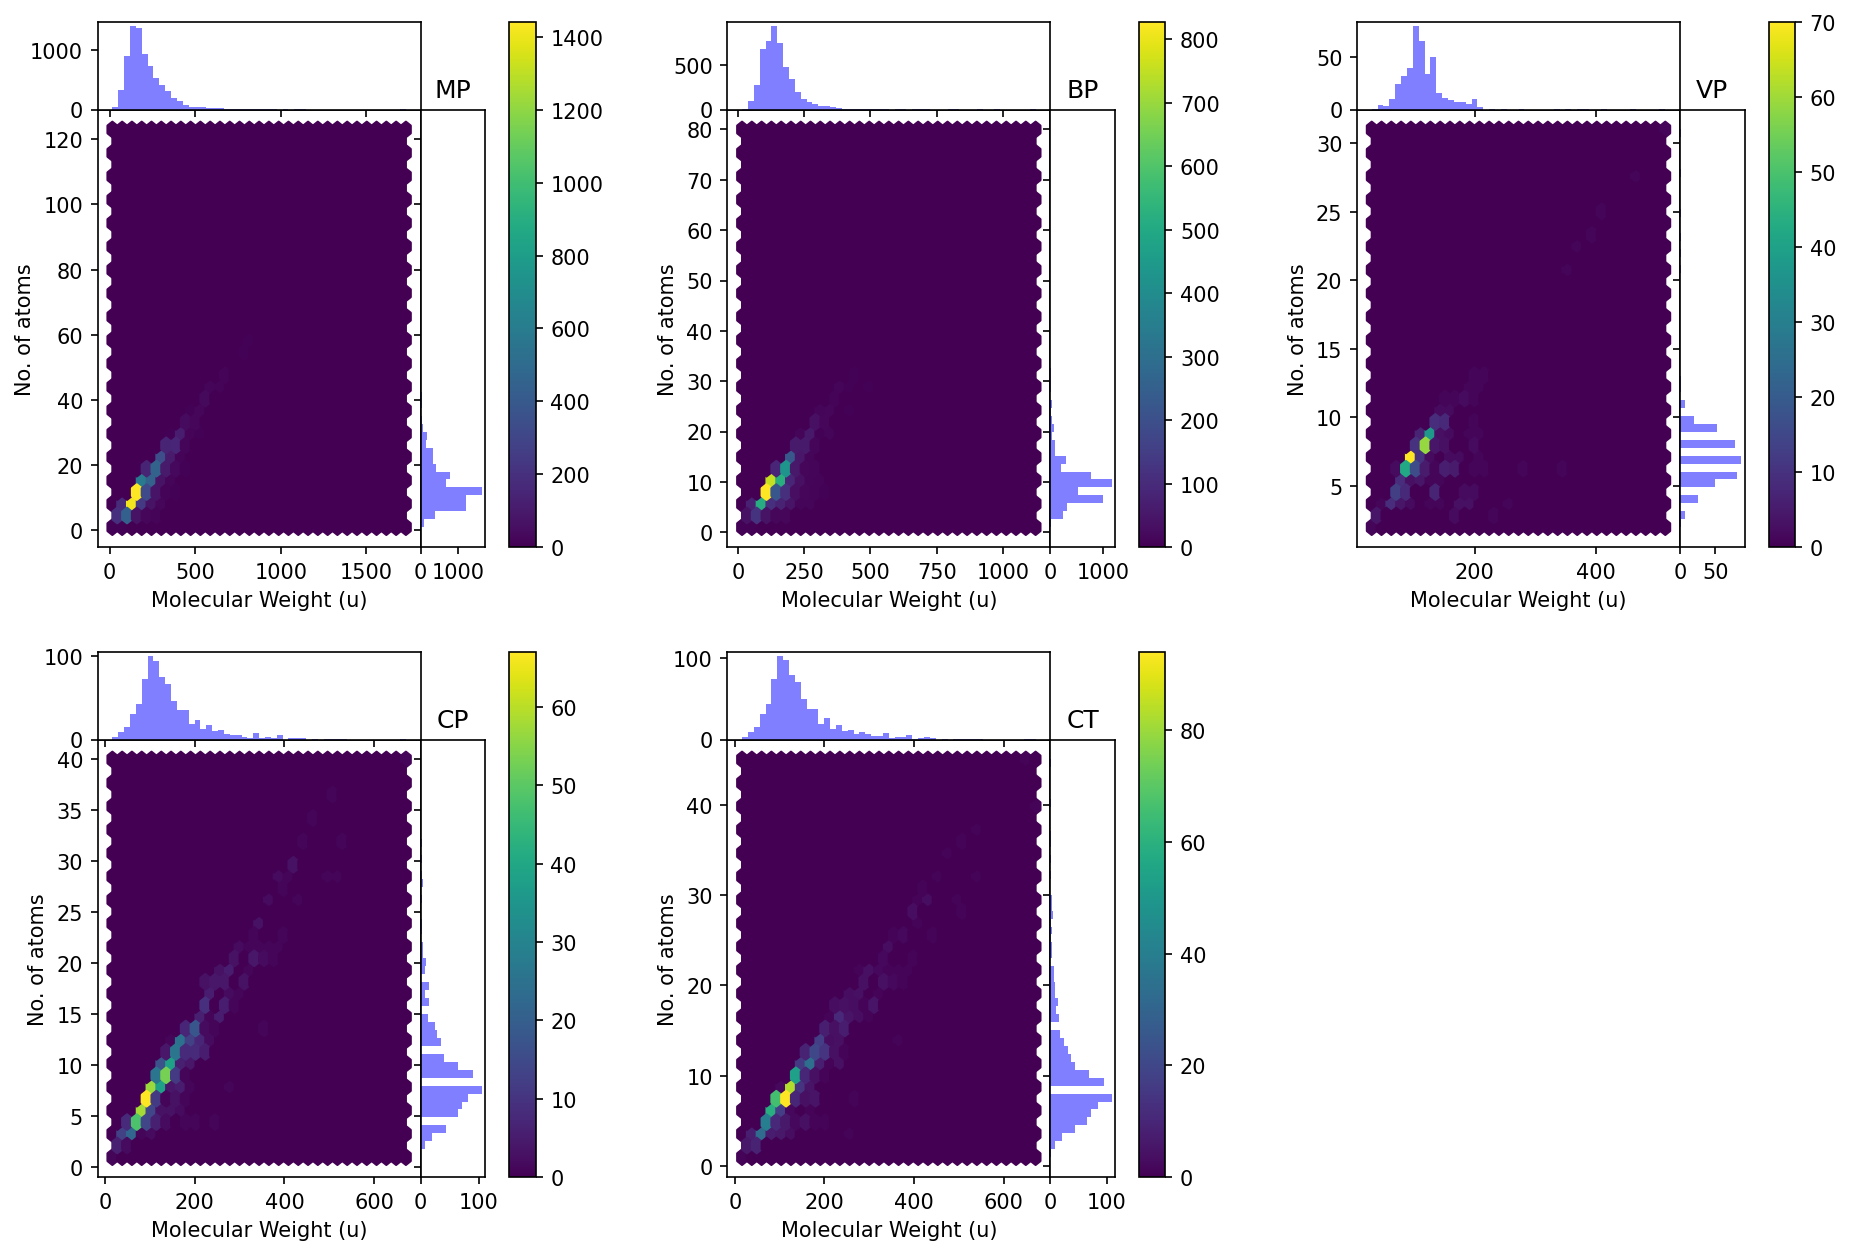

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure with appropriate size
fig = plt.figure(figsize=(15, 10), dpi=150)

# Define grid layout for subplots
gs = fig.add_gridspec(2, 3, hspace=0.2, wspace=0.3)

x_var = "MolecularWeight"
y_var = "No. of atoms"
    
for idx, data_dir in enumerate(processed_data_dirs):
    df = pd.read_csv(data_dir / "analysis_data/molecule_analysis_results.csv")
    # Calculate position in grid
    # ax = fig.add_subplot(gs[idx // 2, idx % 2])
    
    if idx < 3:
        ax = fig.add_subplot(gs[0, idx])
    else:
        ax = fig.add_subplot(gs[1, idx-3])
    
    # Create hexbin plot directly on subplot
    plt.hexbin(df[x_var], df[y_var], gridsize=30, cmap='viridis')
    plt.colorbar()
    
    # Add marginal distributions
    divider = make_axes_locatable(ax)
    
    # Top margin distribution
    ax_top: plt.Axes = divider.append_axes("top", size="20%", pad=0)
    ax_top.hist(df[x_var], bins=50, color='blue', alpha=0.5)
    ax_top.set_xticklabels([])
    
    # Right margin distribution
    ax_right: plt.Axes = divider.append_axes("right", size="20%", pad=0)
    ax_right.hist(df[y_var], bins=50, orientation='horizontal', color='blue', alpha=0.5)
    ax_right.set_yticklabels([])
    ax_right.set_title(f'{titles[idx]}')
    
    # Labels and title
    ax.set_xlabel('Molecular Weight (u)')
    ax.set_ylabel(y_var)
    # ax.set_title(f'{x_var} vs {y_var}')
    
# Remove empty subplot
# if len(processed_data_dirs) % 2 != 0:
#     fig.delaxes(fig.add_subplot(gs[2, 1]))

# plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig(plots_dir / 'mol_weight_vs_atomic_size.pdf', dpi=150, bbox_inches='tight')
plt.show()

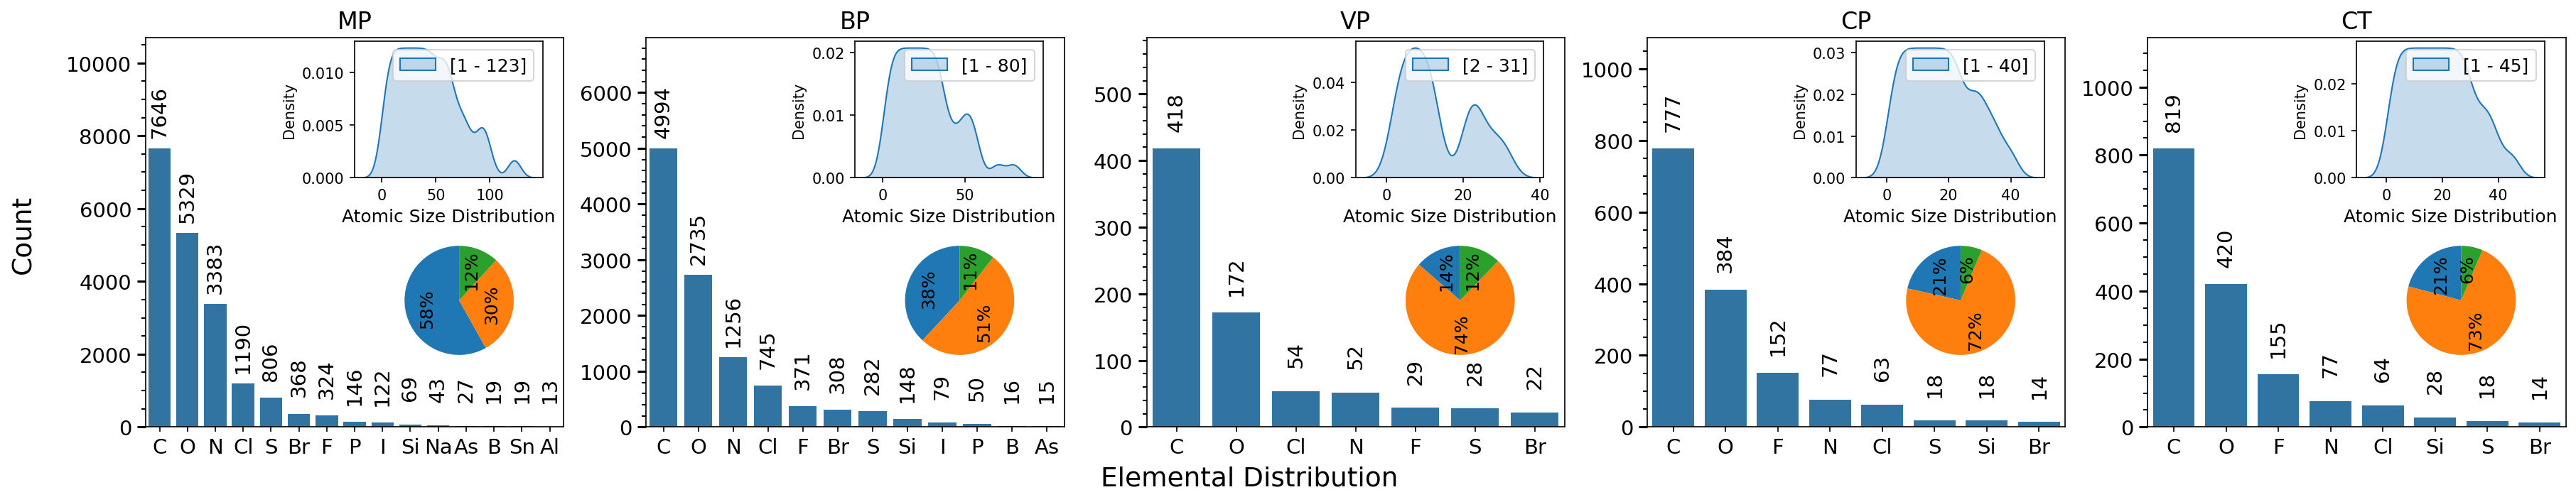

In [40]:
%matplotlib inline
# Create a 3x3 grid of subplots
plt.close('all')
# fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)
fig, axes = plt.subplots(1, 5, figsize=(25, 5), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    ax = axes[i]
    analysis_file = data_dir / 'analysis_data/elemental_distribution.csv'
    df_elemental_distribution = pd.read_csv(analysis_file)
    
    # remove counts < 10
    df_elemental_distribution = df_elemental_distribution[df_elemental_distribution['Count'] >= 10]
    
    sns.barplot(data=df_elemental_distribution, x='Element', y='Count', ax=ax, legend=False)
    ax.set_xlabel('')  # Remove individual X labels
    ax.set_ylabel('')  # Remove individual Y labels
    
    # _title = f'Dataset: {total_counts[i]}'
    # ax.set_title(f'{titles[i]} ({_title})', fontsize=14)  # Set individual titles
    ax.set_title(titles[i], fontsize=16)  # Set individual titles
    # ax.legend([_title], loc='upper left', fontsize=12)
    
    # Add count numbers on top of each bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            rotation='vertical',
            xytext=(0, 25),  # 9 points vertical offset
            textcoords='offset points',
            fontsize=14
        )
    
    # increase y-axis limits by 10% to avoid cutting off the top of the bars
    ax.set_ylim(0, 1.4 * df_elemental_distribution['Count'].max())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', width=1.5, length=6, which='major')
    ax.tick_params(axis='y', width=1, length=3, which='minor')
    
    # inset the atomic size distribution plot
    atomic_size_distribution_file = data_dir / 'analysis_data/size_distribution.csv'
    df_atomic_size_distribution = pd.read_csv(atomic_size_distribution_file)
    # df_atomic_size_distribution - columns: 'No. of atoms', 'Count'
    
    # Create inset axes
    # [x0, y0, width, height]
    inset_ax = ax.inset_axes([0.5, 0.64, 0.45, 0.35])  # Adjust the position and size as needed
    sns.kdeplot(df_atomic_size_distribution['No. of atoms'], ax=inset_ax, bw_adjust=0.5, fill=True)
    inset_ax.set_xlabel('Atomic Size Distribution', fontsize=12)
    atomic_size_min = df_atomic_size_distribution['No. of atoms'].min()
    atomic_size_max = df_atomic_size_distribution['No. of atoms'].max()
    range_text = f'[{atomic_size_min} - {atomic_size_max}]'
    inset_ax.legend([range_text], loc='upper right', fontsize=12)
    
    inset_ax2 = ax.inset_axes([0.5, 0.15, 0.5, 0.35])
    df_structural_distribution = pd.read_csv(data_dir / 'analysis_data/structural_distribution.csv')
    # print(df_structural_distribution.head())
    inset_ax2.pie(
        df_structural_distribution['Count'], 
        autopct='%.0f%%', 
        startangle=90,
    )
    
    for text in inset_ax2.texts:
        text.set_fontsize(12)
        text.set_rotation(text.get_rotation() + 90)
    
    ax.tick_params(axis='both', labelsize=14)
    
# Remove the last subplot (bottom-right) if it exists
# if len(processed_data_dirs) < 6:
#     fig.delaxes(axes[-1])
    
# Add common X and Y labels
fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=18)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=18)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.savefig(plots_dir / 'elemental_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

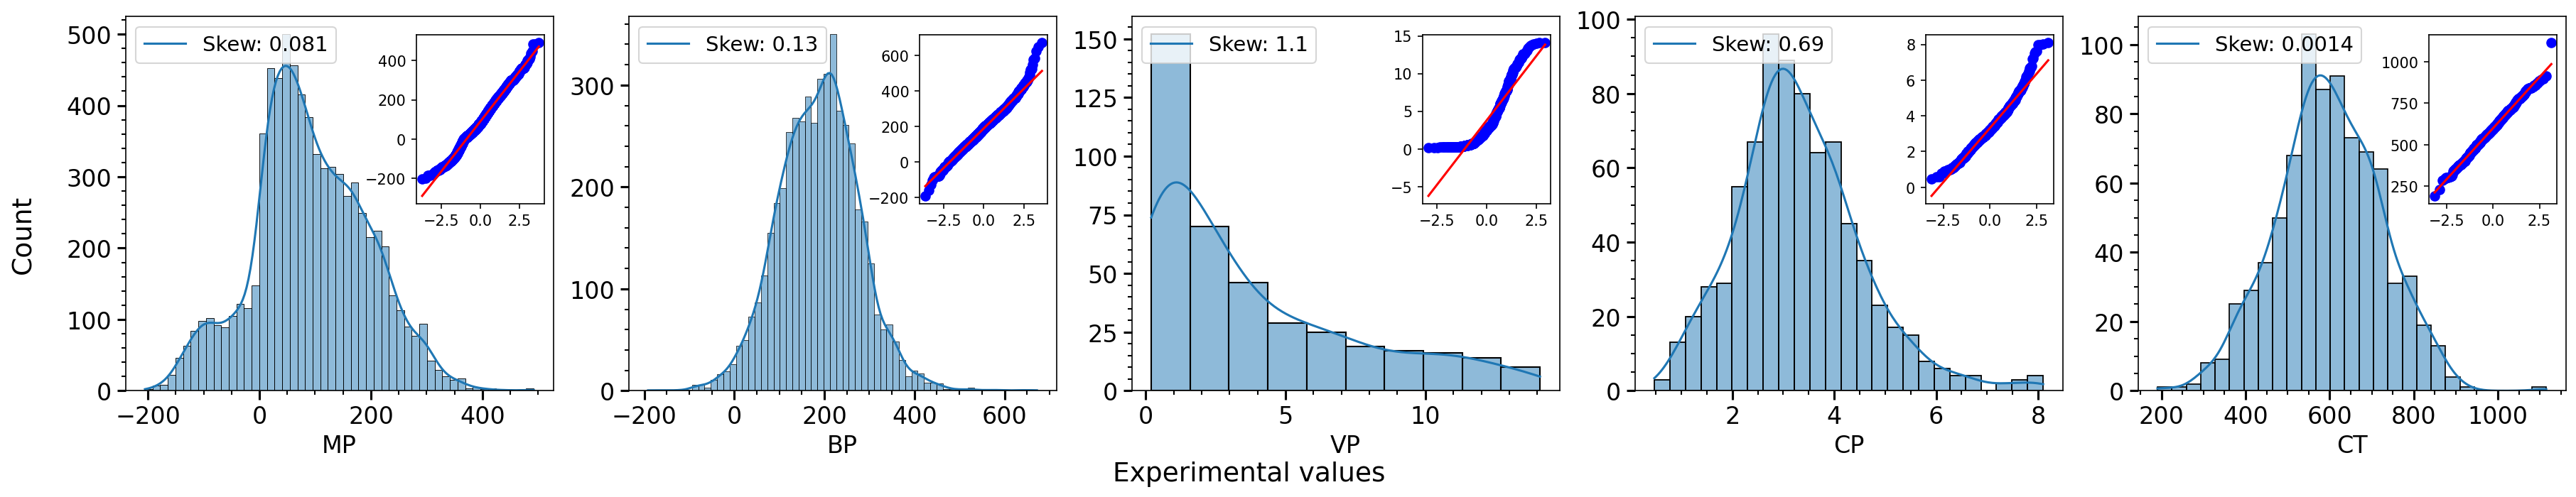

In [25]:
# Create a 3x3 grid of subplots
plt.close('all')
# fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)
# fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    
    csv_file = data_dir.parent / (data_dir.name.replace('_processed_data', '') + '.csv')
    
    df = pd.read_csv(csv_file)
    y: pd.Series = None
    for col_name in df.columns:
        if col_name.startswith('Processed'):
            y = df[col_name]
            break
    
    if y is None:
        continue
    
    # print(data_dir.name, y.shape, csv_file.name)
    ax = axes[i]
    # histplot with KDE
    sns.histplot(y, kde=True, ax=ax)  
    # ax.set_title('')
    # ax.set_title(titles[i], fontsize=14)
    # ax.set_xlabel('')
    ax.set_xlabel(titles[i], fontsize=16)
    ax.set_ylabel('')
    
    ax.minorticks_on()
    
    # set skewness and kurtosis as legend
    skewness = y.skew()
    ax.legend([f'Skew: {sigfig.round(skewness, 2)}'], loc='upper left', fontsize=14)
    # ax.text(0.05, 0.95, f'Skew: {sigfig.round(skewness, 2)}', transform=ax.transAxes, fontsize=12)
    
    inset_ax = ax.inset_axes([0.68, 0.50, 0.3, 0.45])
    stats.probplot(y, dist="norm", plot=inset_ax)
    inset_ax.set_xlabel('')
    inset_ax.set_ylabel('')
    inset_ax.set_title('')
    # inset_ax.set_title('Q-Q Plot')
    
    ax.tick_params(width=1.5, length=6, which='major')
    ax.tick_params(width=1, length=3, which='minor')
    
    # increate tick labels font size
    ax.tick_params(axis='both', labelsize=16)
    
# Remove the last subplot (bottom-right) if it exists
# if len(processed_data_dirs) < 6:
#     fig.delaxes(axes[-1])

# Add common X and Y labels
fig.text(0.5, 0.05, 'Experimental values', ha='center', va='center', fontsize=18)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=18)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.savefig(plots_dir / 'y_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

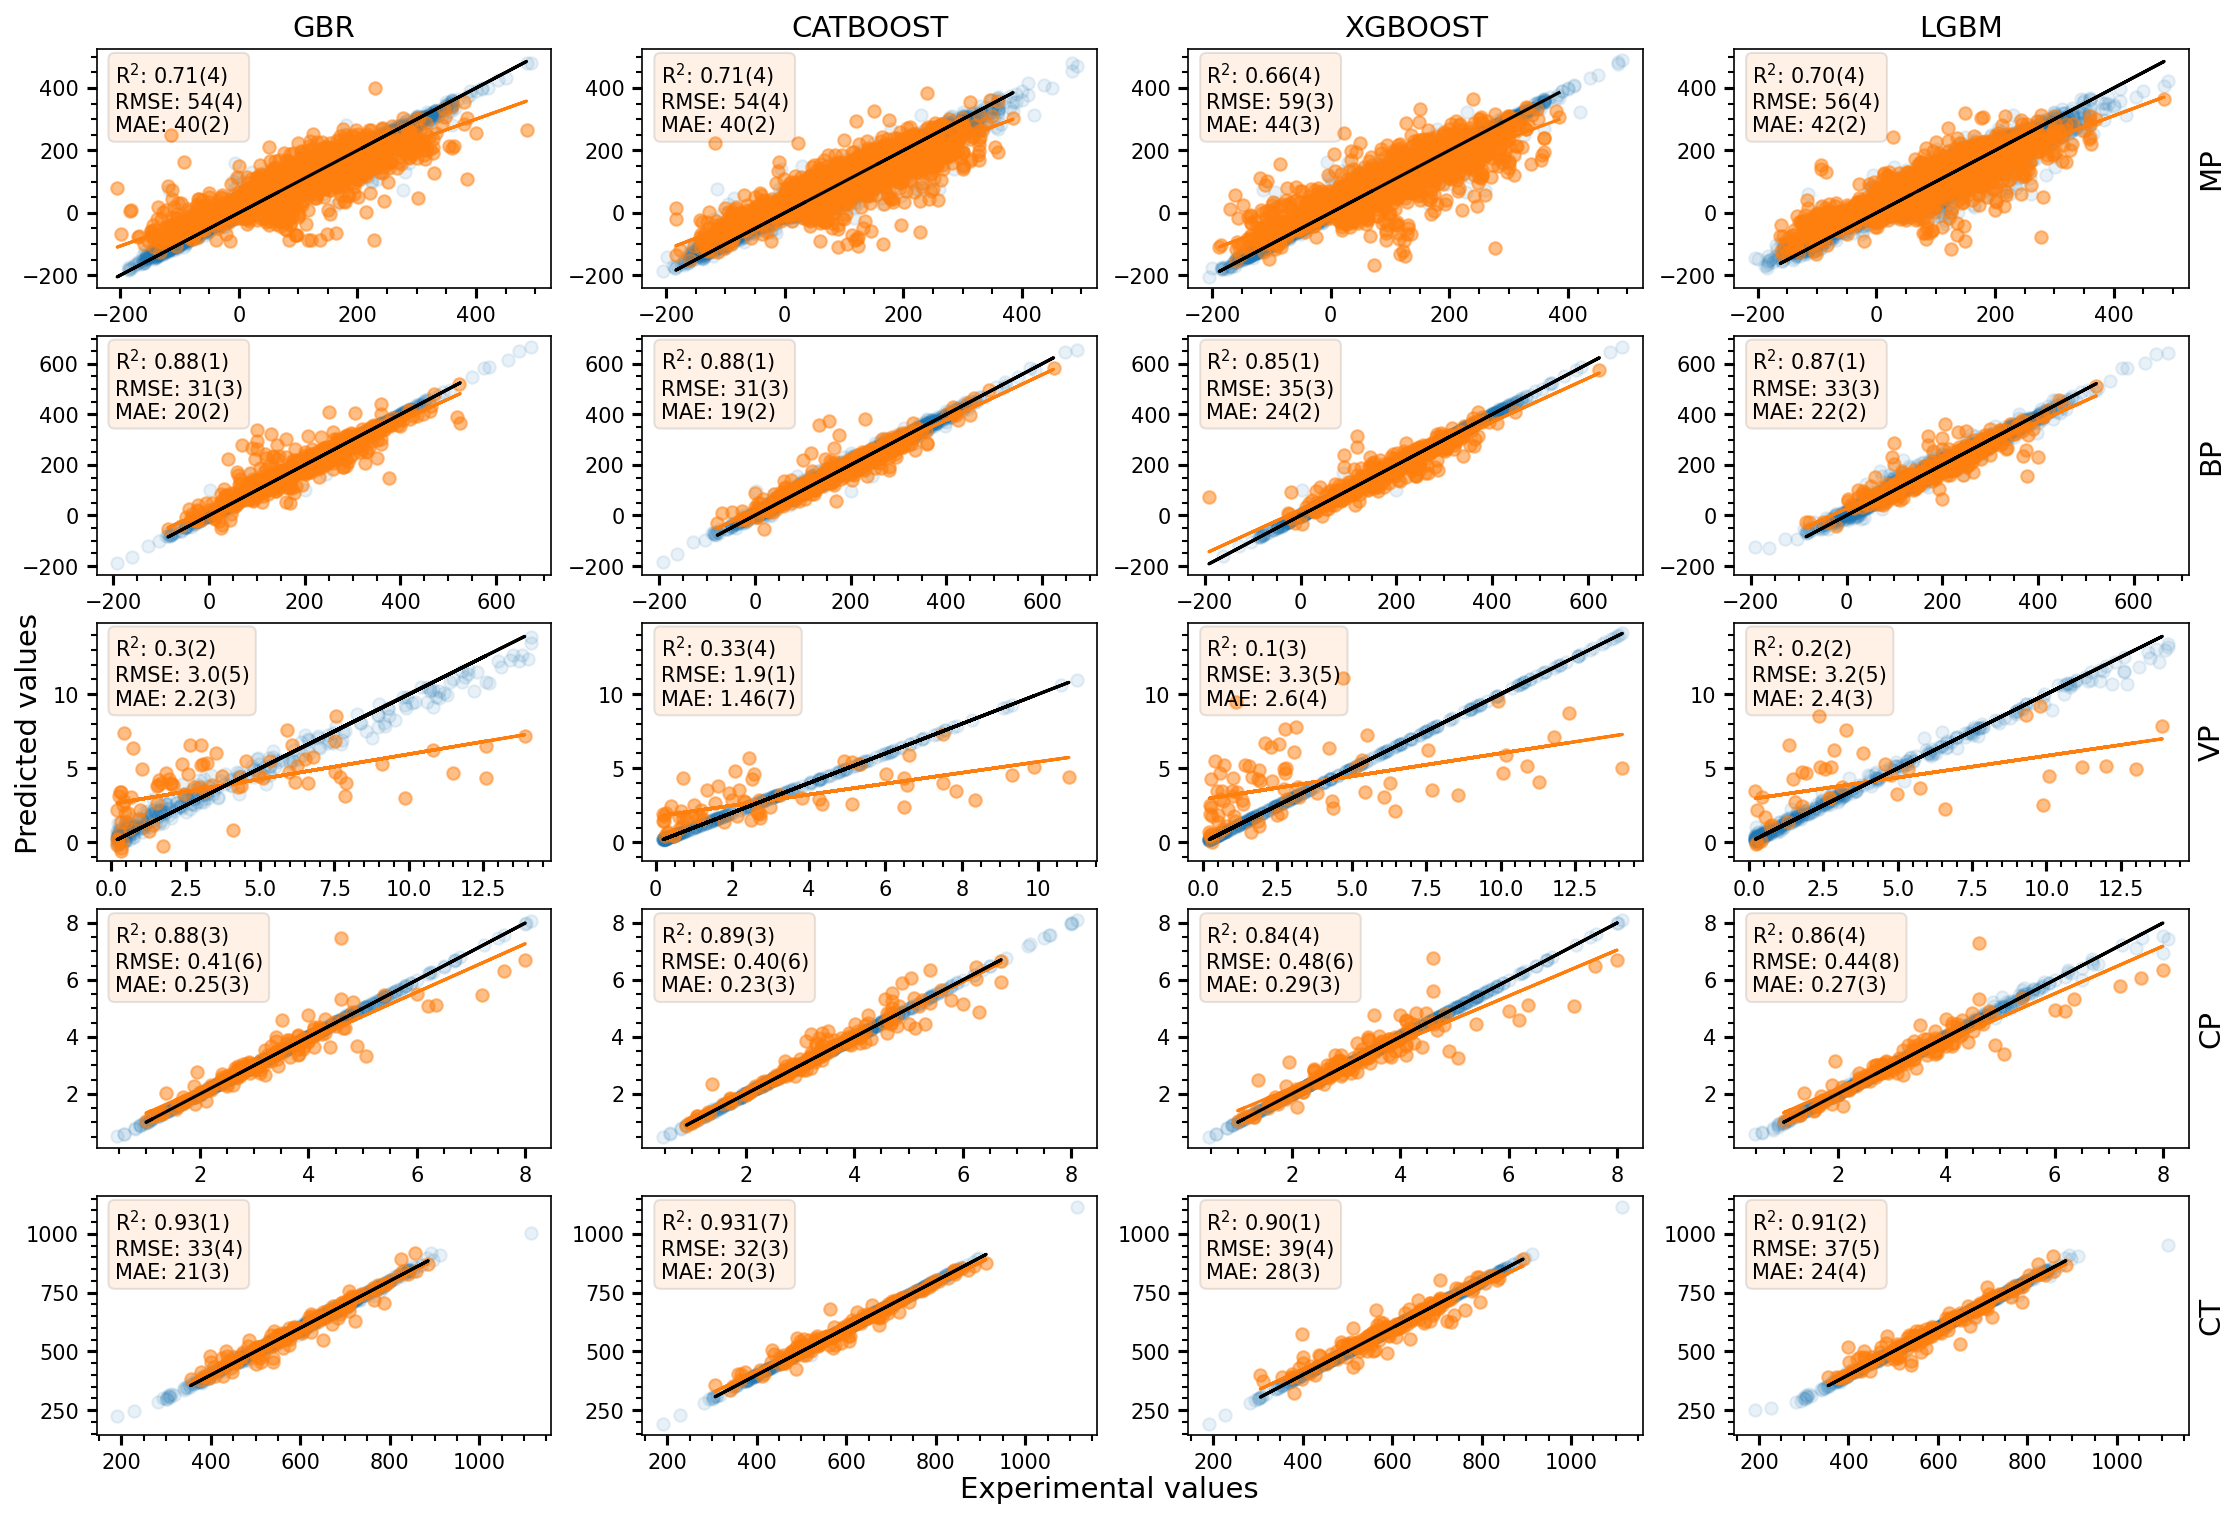

In [24]:
plt.close('all')
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 12), dpi=150, sharey='row')
# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()
nfold = 5

# models = ['gbr', 'xgboost', 'catboost', 'lgbm']
for ind, dir in enumerate(processed_data_dirs):
    # print(dir.name)
    for i, model in enumerate(models):
        # print(titles[i], model)
        ax = axes[ind * 4 + i]
        
        # shared y-axis for all subplots in this row
        # print(ind * 4 + i)
        embeddings = 'mol2vec_embeddings'
        method = 'default'
        # method = 'best_model'
        if model == 'gbr':
            method = 'best_model'
        
        # method += '_cleaned_xgboost'
        
        pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
        loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'

        cv_scores_file = loc / f'{pre_trained_filename}.cv_scores.json'
        datfile = loc / f'{pre_trained_filename}.dat.json'

        if not cv_scores_file.exists() or not datfile.exists():
            continue
        
        cv_scores_info = json.load(open(cv_scores_file, 'r'))
        cv_scores = cv_scores_info[f'{nfold}']
        
        data = json.load(open(datfile, 'r'))

        y_true_test = data["test"]["y_true"]
        y_pred_test = data["test"]["y_pred"]
        y_linear_fit_test = data["test"]["y_linear_fit"]
        y_linear_fit_train = data["train"]["y_linear_fit"]
        
        y_true_train = data["train"]["y_true"]
        y_pred_train = data["train"]["y_pred"]

        metrics = ["r2", "rmse", "mae"]
        test_scores = {}
        train_scores = {}

        for v in ["test", "train"]:
            for k in metrics:
                mean = cv_scores[v][k]["mean"]
                std = cv_scores[v][k]["std"]
                if v == "test":
                    test_scores[k] = sigfig.round(mean, std, sep="external_brackets")
                else:
                    train_scores[k] = sigfig.round(mean, std, sep="external_brackets")

        ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
        ax.scatter(y_true_test, y_pred_test, color="C1", label="Test", alpha=0.5)
        ax.plot(y_true_test, y_linear_fit_test, color="C1", linewidth=1.5)
        
        ax.plot(y_true_test, y_true_test, color="k")
        
        if i == len(models) - 1:
            ax.set_ylabel(titles[ind], fontsize=14)
            ax.yaxis.set_label_position("right")
            
        if ind == 0:
            ax.set_title(model.upper(), fontsize=14)
        
        textstr_test = "\n".join(
            (
                f'R$^2$: {test_scores["r2"]}',
                f'RMSE: {test_scores["rmse"]}',
                f'MAE: {test_scores["mae"]}',
            )
        )

        ax.text(
            0.04,
            0.95,
            textstr_test,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="C1", alpha=0.1),
        )
        
        ax.minorticks_on()
        ax.tick_params(width=1.5, length=5, which='major')
        ax.tick_params(width=1, length=3, which='minor')
        ax.yaxis.set_tick_params(labelleft=True)
        
# plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.text(0.5, 0.08, 'Experimental values', ha='center', va='center', fontsize=14)
fig.text(0.1, 0.5, 'Predicted values', ha='center', va='center', rotation='vertical', fontsize=14)
fig.savefig(plots_dir / 'model_predictions.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Create the joint plot
def create_residual_joint_plot(y_true, y_pred):
    # Calculate residuals
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)

    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    
    # residuals = actual - predicted
    residuals = y_true - y_pred
    
    # A central scatter plot with contour lines showing residuals vs. predicted values
    # A histogram on top showing the distribution of predicted values
    # A histogram on the right showing the distribution of residuals
    
    # Create joint plot
    g = sns.JointGrid(x=y_pred, y=residuals)
    # g = sns.JointGrid(x=y_true, y=residuals)
    
    # Add contour plot in the center
    g.plot_joint(sns.kdeplot, cmap='Blues', levels=8)
    
    # Add histograms on the margins
    g.plot_marginals(sns.histplot, color='navy', bins=30)
    
    # Add reference line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Customize labels and title
    g.ax_joint.set_xlabel("Predicted Values")
    g.ax_joint.set_ylabel("Residuals")
    
    # Add contour lines
    sns.kdeplot(x=y_pred, y=residuals, ax=g.ax_joint, 
                levels=8, color='black', alpha=0.5)
    
    # Add y=0 horizontal line
    g.ax_joint.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    return g

ind = 1
dir = processed_data_dirs[ind]
print(dir.name)
model = 'catboost'
embeddings = 'mol2vec_embeddings'
method = 'default'
# method = 'best_model'
if model == 'gbr':
    method = 'best_model'
pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'
datfile = loc / f'{pre_trained_filename}.dat.json'

data = json.load(open(datfile, 'r'))
y_true_test = data["test"]["y_true"]
y_pred_test = data["test"]["y_pred"]
y_linear_fit_test = data["test"]["y_linear_fit"]

create_residual_joint_plot(y_true_test, y_pred_test)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

def create_residual_subplot(y_true: np.ndarray, y_pred: np.ndarray, ax: plt.Axes, prop: str):
    """Creates a residual plot with density contours on a given matplotlib axis."""
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    
    residuals = y_true - y_pred
    
    # Create scatter plot with density
    sns.kdeplot(x=y_pred, y=residuals, ax=ax, color='navy', levels=8)
    
    # Add histograms on both axes
    divider = make_axes_locatable(ax)
    ax_histx: plt.Axes = divider.append_axes("top", 0.8, pad=0.1)
    ax_histy: plt.Axes = divider.append_axes("right", 0.8, pad=0.1)
    
    # Plot histograms
    sns.histplot(x=y_pred, ax=ax_histx, color='navy', bins=30)
    sns.histplot(y=residuals, ax=ax_histy, color='navy', bins=30, orientation='horizontal')
    
    # Remove histogram axis labels
    ax_histx.set_xticklabels([])
    ax_histy.set_yticklabels([])
    
    # Add reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Customize labels
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.text(0.05, 0.95, prop, transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Create figure with subplots
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

# Define titles and positions
properties = ['MP', 'BP', 'VP', 'CT', 'CP']
positions = [gs[0, 0], gs[0, 1], gs[0, 2], gs[1, 0], gs[1, 1]]

counter = 0
for prop, pos in zip(properties, positions):
    ax = fig.add_subplot(pos)
    model = 'catboost'
    embeddings = 'mol2vec_embeddings'
    method = 'default'
    pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
    
    # Load data for each property
    dir = processed_data_dirs[properties.index(prop)]
    datfile = dir / f'pretrained_models/{model}/{embeddings}/{method}/{pre_trained_filename}.dat.json'
    data = json.load(open(datfile, 'r'))
    y_true_test = data["test"]["y_true"]
    y_pred_test = data["test"]["y_pred"]
    
    create_residual_subplot(y_true_test, y_pred_test, ax, prop)

    # ax.set_title(f"{prop} Residuals")
    counter += 1
    
plt.tight_layout()
fig.savefig(plots_dir / f'{pre_trained_filename}_residual_plot.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
plt.close('all')
fig, ax = plt.subplots(dpi=150)
# models = ['gbr', 'xgboost', 'catboost', 'lgbm']
models = ['gbr', 'catboost', 'lgbm', 'xgboost']
x_models = [x.upper() for x in models]


r2_metrics = {}

for i, data_dir in enumerate(processed_data_dirs):
    color = f'C{i}'
    r2_metrics[data_dir.name] = {}
    for embeddings in ['mol2vec_embeddings', 'VICGAE_embeddings']:
        r2_metrics[data_dir.name][embeddings] = {}
        
        y_r2 = []
        y_err_r2 = []
        
        for model in models:
            method = 'default'
            if model == 'gbr':
                method = 'best_model'
                
            r2_metrics[data_dir.name][embeddings][model] = {}
                
            pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
            loc = data_dir / f'pretrained_models/{model}/{embeddings}/{method}/'
            
            # print(data_dir.name, model, embeddings, method)
            name = data_dir.name.replace('_processed_data', '')
            name = name.replace('_topelements', '')
            
            resultsfile = loc / f'{pre_trained_filename}.results.json'
            datfile = loc / f'{pre_trained_filename}.dat.json'

            if not resultsfile.exists() or not datfile.exists():
                continue
            
            results = json.load(open(resultsfile, 'r'))
            metric = 'r2'
            
            r2_mean = float(results["cv_scores"]['test'][metric]["mean"])
            r2_std = float(results["cv_scores"]['test'][metric]["std"])
            
            y_r2.append(r2_mean)
            y_err_r2.append(r2_std)
            
            r2_metrics[data_dir.name][embeddings][model]['test'] = {
                'mean': r2_mean,
                'std': r2_std
            }
            r2_metrics[data_dir.name][embeddings][model]['train'] = {
                'mean': float(results["cv_scores"]['train'][metric]["mean"]),
                'std': float(results["cv_scores"]['train'][metric]["std"])
            }

        
        fmt = 'o'
        if embeddings == 'VICGAE_embeddings':
            fmt = 's'
            continue
        
        ax.errorbar(
            x_models, 
            y_r2, 
            yerr=y_err_r2, 
            fmt=fmt,
            c=color, 
            label=f'{titles[i]}'
        )
        
ax.legend()
# ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('R$^2$')
ax.set_ybound(0.0, 1.0)
ax.tick_params(axis='y', width=1.5, length=6, which='major')
ax.tick_params(axis='y', width=1, length=3, which='minor')
# fig.savefig(plots_dir / 'r2_scores.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
models, r2_metrics['tmpC_topelements_processed_data']['mol2vec_embeddings']

def get_scores_for_all_models(
    name = 'tmpC_topelements_processed_data', embeddings = 'mol2vec_embeddings', data_type = 'test'
):
    scores = []
    errors = []
    # print(name, embeddings, data_type)
    for model in models:
        scores.append(r2_metrics[name][embeddings][model][data_type]['mean'])
        errors.append(r2_metrics[name][embeddings][model][data_type]['std'])
        
    return scores, errors

# get_scores_for_all_models()


In [ ]:
from matplotlib.legend_handler import HandlerTuple
plt.close('all')

data_names = [d.name for d in processed_data_dirs]

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

bar_width = 0.1
gap_width = 0.05  # Gap between Mol2Vec/VICGAE pairs
model_gap = 1   # Add gap between different models

# index = np.arange(len(models))
index = np.arange(len(models)) * (1 + model_gap)  # Multiply by (1 + model_gap) to space out models

n_datasets = len(data_names)
# total_width = bar_width * (n_datasets * 2)
total_width = bar_width * (n_datasets * 2) + gap_width * (n_datasets - 1)  # Adjust total width to account for gaps

# name = data_names[0]
# Dictionary to store handles for legend
legend_handles = []
titles = ['MP', 'BP', 'VP', 'CP', 'CT']

for i, (name, title) in enumerate(zip(data_names, titles)):
    mol2vec_scores, mol2vec_errors = get_scores_for_all_models(name, embeddings='mol2vec_embeddings')
    vicgae_scores, vicgae_errors = get_scores_for_all_models(name, embeddings='VICGAE_embeddings')
    
    # offset = i * bar_width * 2 - total_width/2 + bar_width/2
    # Modify offset calculation to include gaps
    offset = i * (bar_width * 2 + gap_width) - total_width/2 + bar_width/2
    
    color = f'C{i}'
    
    h1 = ax.barh(index - offset + bar_width, mol2vec_scores, bar_width, xerr=mol2vec_errors, 
            color=color, alpha=1)
    h2 = ax.barh(index - offset, vicgae_scores, bar_width, xerr=vicgae_errors,
            color=color, alpha=0.5)

    # Add both handles with custom labels
    legend_handles.extend([(h1, h2, f'{title}: Mol2Vec, VICGAE')])
    
# Adding labels
ax.set_xlabel('R$^2$', fontsize=14)
# ax.set_ylabel('Models')
ax.set_yticks(index)
ax.set_yticklabels(x_models, fontsize=14)
ax.set_xlim(0, 1.0)

# increase x-tick label font size
ax.tick_params(axis='x', labelsize=14)

# place the legend outside the plot
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncols=2)

# Create custom legend with combined labels
flat_handles = [(h[0], h[1]) for h in legend_handles]
labels = [h[2] for h in legend_handles]
ax.legend(flat_handles, labels, loc='upper left', bbox_to_anchor=(1, 1), 
         handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12)

ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Show plot
plt.tight_layout()
fig.savefig(plots_dir / 'r2_scores_bar.pdf', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
num = 5
index, bar_width, index + bar_width / num, index - bar_width / num

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Sample molecules with their descriptions
sample_molecules = {
    'aspirin': 'CC(=O)OC1=CC=CC=C1C(=O)O',  # Contains aromatic ring, ester, carboxylic acid
    'caffeine': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # Contains imidazole ring, amides
    'testosterone': 'CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C',  # Complex ring system with ketone
    'benzene': 'C1=CC=CC=C1',  # Simple aromatic ring
    'glucose': 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O',  # Multiple alcohols, cyclic ether
    'alanine': 'CC(C(=O)O)N',  # Amino acid: amine and carboxylic acid
    'ethanol': 'CCO',  # Simple alcohol
    'acetone': 'CC(=O)C',  # Simple ketone
    'morphine': 'CN1CC[C@]23[C@H]4C1=C[C@@H]([C@H]2O)C=C[C@H]3O4',  # Complex natural product
    'ibuprofen': 'CC(C)CC1=CC=C(C=C1)[C@H](C)C(=O)O'  # Aromatic ring, carboxylic acid
}

def identify_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    functional_groups = {
        'alcohol': '[OH]',
        'carboxylic_acid': '[C](=O)[OH]',
        'amine': '[NH2]',
        'aldehyde': '[CH]=O',
        'ketone': '[C](=O)[C]',
        'ether': '[O;R0]([C])[C]',
        'ester': '[C](=O)[O][C]',
        'amide': '[C](=O)[N]',
        'phenol': '[OH]c1ccccc1',
        'alkene': '[C]=[C]',
        'alkyne': '[C]#[C]'
    }
    
    results = {}
    for name, smarts in functional_groups.items():
        pattern = Chem.MolFromSmarts(smarts)
        matches = mol.GetSubstructMatches(pattern)
        results[name] = len(matches)
    return results

def analyze_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return {
        'total_rings': rdMolDescriptors.CalcNumRings(mol),
        'aromatic_rings': rdMolDescriptors.CalcNumAromaticRings(mol),
        'aliphatic_rings': rdMolDescriptors.CalcNumAliphaticRings(mol),
        'saturated_rings': rdMolDescriptors.CalcNumSaturatedRings(mol),
        'heterocycles': rdMolDescriptors.CalcNumHeterocycles(mol)
    }

# Test the functions
for name, smiles in sample_molecules.items():
    print(f"\nAnalyzing {name.upper()} ({smiles})")
    print("\nFunctional Groups:")
    fg_results = identify_functional_groups(smiles)
    for group, count in fg_results.items():
        if count > 0:
            print(f"{group}: {count}")
            
    print("\nRing Analysis:")
    ring_results = analyze_rings(smiles)
    for ring_type, count in ring_results.items():
        print(f"{ring_type}: {count}")
    print("-" * 50)

In [ ]:
# Sample molecules with their descriptions
glucose_smi = 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O'
glucose_smarts = 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O'

In [ ]:
Chem.MolFromSmiles('CN1CC[C@]23[C@H]4C1=C[C@@H]([C@H]2O)C=C[C@H]3O4')
# Chem.MolFromSmarts('[O;R0]([C])[C]')

embedder, transformation, scaling, r2, rmse, mae
vicgae, none, none, 0.27 (0.24), 2.28 (0.41), 1.72 (0.24)
vicgae, log1p, none, 0.37 (0.23), 0.52 (0.07), 0.42 (0.04)
vicgae, sqrt, none, 0.37 (0.23), 0.61 (0.09), 0.48 (0.05)
vicgae, boxcox, none, 0.41 (0.18), 0.93 (0.11), 0.74 (0.07)
vicgae, yeo_johnson, none, 0.39 (0.21), 0.69 (0.09), 0.55 (0.05)

vicgae, none, standard, 0.56 (0.08), 1.83 (0.20), 1.40 (0.15)
vicgae, none, minmax, 0.50 (0.10), 1.92 (0.13), 1.41 (0.12)
vicgae, none, maxabs, 0.50 (0.06), 1.94 (0.27), 1.44 (0.10)
vicgae, none, robust, 0.53 (0.08), 1.88 (0.14), 1.41 (0.06)
vicgae, none, quantile, 0.54 (0.03), 1.89 (0.22), 1.34 (0.16)
vicgae, none, powertransformer, 0.53 (0.11), 1.90 (0.39), 1.34 (0.21)
